# Projekt 4: Generalna ocena jakości modeli przestrzennych RNA

In [1]:
# %pip install pandas biopython joblib scikit-learn catboost matplotlib

In [2]:
import os
from sklearn.metrics import make_scorer
import numpy as np
from joblib import Parallel, delayed
import xml.etree.ElementTree as ET
from Bio.PDB import PDBParser
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

1. Zapoznanie się z udostępnionymi zbiorami danych i ewentualne przetransformowanie ich do postaci ułatwiającej zastosowanie technik sztucznej inteligencji np. integracja danych składowych przechowywanych w różnych formatach z wykorzystaniem jednej spójnej reprezentacji.

In [3]:
DATASET_PATH = Path("./RNA-Puzzles")

rna_dataset_path = Path("./RNA-Puzzles")

# Tworzenie listy numerów puzzli, wykluczając numer 7
puzzle_numbers = [f"pz{num:02}" for num in range(1, 11) if num != 7]

In [4]:
def extract_motif_data(puzzle_list: list[str]) -> pd.DataFrame:
    combined_data = pd.DataFrame()
    for puzzle_id in puzzle_list:
        motif_data = pd.read_csv(
            rna_dataset_path / f"{puzzle_id}/filter-results.txt",
            sep="\t",
            header=None,
            names=[
                "filename",
                "segment_count",
                "residue_count",
                "nucleotide_ranges",
                "sequences",
            ],
        )
        motif_data["puzzle_id"] = puzzle_id
        combined_data = pd.concat([combined_data, motif_data])

    # Filtracja po liczbie segmentów
    filtered_data = combined_data[combined_data["segment_count"] >= 3]
    return filtered_data.reset_index(drop=True)
def load_xml_as_dataframe(xml_file_path: Path) -> pd.DataFrame:
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    data_records = [
        {
            "filename": element.find("description").find("filename").text,
            "score": element.find("score").text,
        }
        for element in root
    ]
    return pd.DataFrame(data_records)

def compile_score_data(puzzle_data: pd.DataFrame) -> pd.DataFrame:
    combined_scores = pd.DataFrame()
    for idx, puzzle_row in puzzle_data.iterrows():
        base_path = rna_dataset_path / f"{puzzle_row['puzzle_id']}"
        score_file_path = base_path / f"{puzzle_row['filename']}-rmsd.xml"

        if score_file_path.exists():
            score_data = load_xml_as_dataframe(score_file_path)
            score_data["solution_directory"] = puzzle_row["filename"]
            score_data["full_path"] = base_path / (
                f"{puzzle_row['filename']}/" + score_data["filename"].apply(lambda x: x[:-4])
            )
            combined_scores = pd.concat([combined_scores, score_data])
        else:
            puzzle_data.drop(idx, inplace=True)

    return combined_scores

def extract_pdb_data(pdb_file_path: Path) -> pd.DataFrame:
    pdb_parser = PDBParser(QUIET=True)
    protein_structure = pdb_parser.get_structure("Protein_Structure", f"{pdb_file_path}.pdb")

    atom_details: list = []
    for model in protein_structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_details.append(
                        {
                            "atom_id": atom.serial_number,
                            "atom_name": atom.name,
                            "residue_name": residue.resname,
                            "chain_id": chain.id,
                            "residue_number": residue.id[1],
                            "x": atom.coord[0],
                            "y": atom.coord[1],
                            "z": atom.coord[2],
                            "occupancy": atom.occupancy,
                            "temperature_factor": atom.bfactor,
                        }
                    )
    return pd.DataFrame(atom_details)

def extract_torsion_angles(tor_file_path: Path, include_ids: bool = False) -> pd.DataFrame:
    torsion_df = pd.read_csv(f"{tor_file_path}.tor", sep="\s+")
    try:
        if not include_ids:
            return torsion_df.drop(columns=["Chain", "ResNum", "Name", "iCode"])
        else:
            return torsion_df.rename(
                columns={
                    "Chain": "chain_id",
                    "ResNum": "residue_number",
                    "Name": "residue_name",
                    "iCode": "icode",
                }
            )
    except:
        return None

def find_max_tor_lines(scores: pd.DataFrame) -> int:
    max_length = 0

# Pętla przez każdą ścieżkę w kolumnie dataset_files_path
    for file_path in scores['full_path']:
        # Parsowanie pliku
        parsed_file = extract_torsion_angles(file_path)
        # Obliczenie długości wyniku zwróconego przez parse_tor_file
        try:
            current_length = len(parsed_file)
        except:
            continue
        # Aktualizacja max_length, jeśli obecna długość jest większa niż dotychczas znaleziony maksimum
        if current_length > max_length:
            max_length = current_length
    return max_length
# Wywołanie funkcji z listą puzzli

def preprocess_torsion_data(torsion_data: pd.DataFrame, fill_value: int = 0) -> np.ndarray:
    # Replace missing entries and flatten the data
    torsion_data = torsion_data.replace("-", fill_value).astype(float).values.flatten()
    padding = max(0, TOTAL_FEATURES - len(torsion_data))
    return np.pad(torsion_data, (0, padding), mode='constant', constant_values=fill_value)

def scale_features(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Normalize features, avoiding division by zero
    def normalize_feature(series: pd.Series) -> pd.Series:
        valid_data = series[series != 0]
        min_val, max_val = valid_data.min(), valid_data.max()
        series[series != 0] = 2 * (valid_data - min_val) / (max_val - min_val) - 1 if max_val > min_val else 0
        return series
    return data_frame.apply(normalize_feature, axis=0)

def assemble_torsion_dataset(score_data: pd.DataFrame) -> pd.DataFrame:
    combined_data = pd.DataFrame()
    for _, record in score_data.iterrows():
        torsion_data = parse_tor_file(record['dataset_files_path'])
        processed_data = preprocess_torsion_data(torsion_data)

        data_frame = pd.DataFrame([processed_data])
        data_frame['score'] = record['score']
        combined_data = pd.concat([combined_data, data_frame])

    # Separate and normalize
    scores_column = combined_data.pop('score')
    normalized_data = scale_features(combined_data)
    normalized_data['score'] = scores_column
    return normalized_data

def process_in_parallel(data_frame: pd.DataFrame) -> pd.DataFrame:
    # Parallel processing setup
    available_cores = max(1, os.cpu_count() - 1)
    partitioned_data = np.array_split(data_frame, available_cores)
    process_function = delayed(assemble_torsion_dataset)
    parallel_results = Parallel(n_jobs=available_cores, verbose=10)(
        process_function(chunk) for chunk in partitioned_data)
    return pd.concat(parallel_results)

def export_torsion_dataset(scores: pd.DataFrame) -> None:
    # Prepare and save dataset
    final_dataset = process_in_parallel(scores)
    final_dataset.to_csv(TORSION_ANGLES_FILE, index=False)

def preprocess_tor_dataset(dataset: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    # Separating features and target variable
    features = dataset.iloc[:, :-1]  # All rows, all columns except the last one
    target = dataset.iloc[:, -1]  # All rows, only the last column

    # Converting DataFrame to numpy arrays
    X = features.to_numpy()
    y = target.to_numpy()

    return X, y
motif_details = extract_motif_data(puzzle_numbers)


In [5]:


# Użycie funkcji do skompilowania danych
compiled_scores = compile_score_data(motif_details)
compiled_scores

,filename,score,solution_directory,full_path
0,1_bujnicki_1_rpr.pdb,4.769,1_solution_0_rpr_A_4_C,RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_bujn...
1,1_bujnicki_2_rpr.pdb,4.594,1_solution_0_rpr_A_4_C,RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_bujn...
2,1_bujnicki_3_rpr.pdb,3.921,1_solution_0_rpr_A_4_C,RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_bujn...
3,1_bujnicki_4_rpr.pdb,4.522,1_solution_0_rpr_A_4_C,RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_bujn...
4,1_bujnicki_5_rpr.pdb,4.616,1_solution_0_rpr_A_4_C,RNA-Puzzles/pz01/1_solution_0_rpr_A_4_C/1_bujn...
...,...,...,...,...
21,10_DING_5_rpr.pdb,4.516,10_0_solution_4LCK_rpr_B_59_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_59_U...
22,10_DING_6_rpr.pdb,3.939,10_0_solution_4LCK_rpr_B_59_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_59_U...
23,10_DING_7_rpr.pdb,4.639,10_0_solution_4LCK_rpr_B_59_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_59_U...
24,10_DING_8_rpr.pdb,5.66,10_0_solution_4LCK_rpr_B_59_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_59_U...


3. Określenie procentowych progów pozwalających podzielić dostępny zbiór danych na część treningową, walidacyjną i ewaluacyjną. Czy rozmiar dostępnego zbioru jest wystarczający? Czy należy go rozbudować? Jeśli tak to w jaki sposób?

In [6]:
# train-validation-test splits -> 70-15-15
VALIDATION_TEST_RATIO: float = 0.15
TRAIN_RATIO: float = 1 - 2 * VALIDATION_TEST_RATIO

assert TRAIN_RATIO > 0 and VALIDATION_TEST_RATIO > 0

In [7]:
# for xd in scores["dataset_files_path"]:
#     print(xd,  len(parse_tor_file(xd)))

4. Określenie sposobu reprezentacji wiedzy, którą dysponujemy (tzn. wektora cech). Czy stosowane będą techniki identyfikacji najistotniejszych cech? Jeśli tak to jakie?

In [8]:



max_tor_lines = find_max_tor_lines(compiled_scores)
max_tor_lines

61

In [9]:
DATA_REPRESENTATIONS_DIR = Path("./resources/datasets/representations")
TORSION_ANGLES_FILE = DATA_REPRESENTATIONS_DIR / "tor_dataset.csv"
ANGLE_MULTIPLIER = 7
MAX_TORSION_LINES = 61
TOTAL_FEATURES = MAX_TORSION_LINES * ANGLE_MULTIPLIER



if not TORSION_ANGLES_FILE.exists():
    export_torsion_dataset(compiled_scores)

In [10]:
DATA_REPRESENTATIONS_DIR = Path("./resources/datasets/representations")
TORSION_ANGLES_FILE = DATA_REPRESENTATIONS_DIR / "tor_dataset.csv"

# Load the dataset from the CSV file
torsion_angles_dataset = pd.read_csv(TORSION_ANGLES_FILE)

# Display the dataset
torsion_angles_dataset

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,score
0,0.0,-0.978661,0.339637,0.463333,-0.969821,-0.442532,-0.809215,0.915860,-0.884387,0.940489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.769
1,0.0,0.925007,0.302262,0.458506,-0.919853,-0.430515,-0.901528,-0.367817,0.971242,0.248807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.594
2,0.0,0.969942,0.310983,0.444815,-0.804548,-0.577312,-0.902394,0.905048,-0.871336,0.939470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.921
3,0.0,-0.907328,0.252716,0.409614,0.987071,-0.394564,-0.753726,-0.340666,0.941621,0.283139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.522
4,0.0,0.960478,0.304328,0.482642,-0.788699,-0.441201,-0.924806,-0.395413,1.000000,0.318126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15699,0.0,0.921765,0.350060,0.465399,-0.833842,-0.343431,-0.887391,-0.499000,0.832146,0.583481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.516
15700,0.0,0.933915,0.485690,0.427908,-0.831433,-0.394316,-0.926236,-0.485149,0.825322,0.675647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.939
15701,0.0,0.904442,0.422146,0.510393,-0.825556,-0.387512,-0.887714,-0.412740,0.901270,0.289614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.639
15702,0.0,0.920129,0.353021,0.379568,-0.880728,-0.366675,-0.906016,-0.484275,0.908835,0.714776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.660


In [11]:


# Preprocess the dataset
X, y = preprocess_tor_dataset(torsion_angles_dataset)

# Retrieve and print shapes of the arrays
X_shape = X.shape
y_shape = y.shape
X_shape, y_shape

((15704, 427), (15704,))

In [12]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.70  # Calculated earlier to account for 15% validation and 15% test
VALID_TEST_RATIO = 0.5  # Split the remaining 30% equally between validation and test

# Split the data into training and validation/testing first
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)

# Split the remaining data equally into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=VALID_TEST_RATIO, random_state=RANDOM_STATE
)

# Calculate the proportions for each dataset
total_data_count = X.shape[0]
train_percentage = X_train.shape[0] / total_data_count * 100
valid_percentage = X_valid.shape[0] / total_data_count * 100
test_percentage = X_test.shape[0] / total_data_count * 100

# Print the sizes and percentages of the datasets
print(
    f"""
    Train size: {X_train.shape} [{train_percentage:.2f}%]
    Valid size: {X_valid.shape} [{valid_percentage:.2f}%]
    Test  size: {X_test.shape} [{test_percentage:.2f}%]
    """
)


    Train size: (10992, 427) [69.99%]
    Valid size: (2356, 427) [15.00%]
    Test  size: (2356, 427) [15.00%]
    


5. Wybór obiecujących technik uczenia maszynowego, które uważacie Państwo, że powinny się sprawdzić podczas rozwiązywania postawionego problemu wraz z uzasadnieniem (np. głębokie sieci neuronowe, SVM, RandomForest ,itd.).

In [13]:
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42
VALID_TEST_SIZE = 0.15  # Assuming this is previously calculated

# Common parameters for all models
common_params = {
    "random_state": RANDOM_STATE,
    "verbose": False
}

# Parameter grids for model tuning
param_grids = {
    "MLP": {
        "hidden_layer_sizes": [(750,),],
        "alpha": [0.0001,],
        "learning_rate": ["invscaling", "adaptive"],
        "learning_rate_init": [0.001],
    },
    "CatBoost": {
        "learning_rate": [0.01, ],
        "depth": [4],
        "l2_leaf_reg": [1, ],
    },
}

# Configured models
regressors = {
    "MLP": MLPRegressor(
        hidden_layer_sizes=(1250,),
        alpha=0.01,
        learning_rate="invscaling",
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=VALID_TEST_SIZE,
        **common_params
    ),
    "CatBoost": CatBoostRegressor(
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=1,
        custom_metric="MAE",
        eval_metric="RMSE",
        early_stopping_rounds=8,
        **common_params
    ),
}

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def root_mean_squared_error(x,y):
    return sqrt(mean_squared_error(x,y))

In [15]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


def find_best_params(Regressor, param_grid: dict) -> None:
    regr = GridSearchCV(Regressor, param_grid, scoring=rmse_scorer, n_jobs=-1, cv=3, verbose=3)

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    print(
        f"""
        {type(Regressor).__name__} best params: {regr.best_params_}
        with RMSE score: {root_mean_squared_error(y_test, y_pred):.3f}
        """
    )

In [16]:
find_best_params(regressors["MLP"], param_grids["MLP"])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=invscaling, learning_rate_init=0.001;, score=-4.929 total time= 2.8min
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=adaptive, learning_rate_init=0.001;, score=-4.929 total time= 2.9min
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=invscaling, learning_rate_init=0.001;, score=-4.868 total time= 2.9min
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=adaptive, learning_rate_init=0.001;, score=-4.868 total time= 3.0min
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=invscaling, learning_rate_init=0.001;, score=-4.988 total time= 3.2min
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(750,), learning_rate=adaptive, learning_rate_init=0.001;, score=-4.988 total time= 3.2min

        MLPRegressor best params: {'alpha': 0.0001, 'hidden_layer_sizes': (750,), 'learning_rate': 'invscaling',

In [17]:
find_best_params(regressors["CatBoost"], param_grids["CatBoost"])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[CV 2/3] END depth=4, l2_leaf_reg=1, learning_rate=0.01;, score=-5.015 total time=  54.2s
[CV 1/3] END depth=4, l2_leaf_reg=1, learning_rate=0.01;, score=-5.104 total time=  54.3s
[CV 3/3] END depth=4, l2_leaf_reg=1, learning_rate=0.01;, score=-5.114 total time=  54.3s

        CatBoostRegressor best params: {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
        with RMSE score: 5.027
        


6. Iteracyjne przeprowadzenie procesu uczenia, określenie wartości parametrów kluczowych dla tego procesu (np. zastosowana funkcja straty, learning rate, optimizer, itd.) i wskazanie czy natrafiliście Państwo na jakieś problemy podczas tego procesu np. przeuczenie i jak Państwo sobie z tymi problemami poradziliście o ile rzeczywiście wystąpiły?

7. Optymalizacja wartości hiperparametrów – czy warto je optymalizować w przypadku rozpatrywanego problemu? Jeśli tak to w jaki sposób?

8. Wybór i uzasadnienie zastosowanych miar oceny, przeprowadzenie procesu ewaluacji uzyskanego(ych) modelu(i), podsumowanie i analiza uzyskanych wyników.

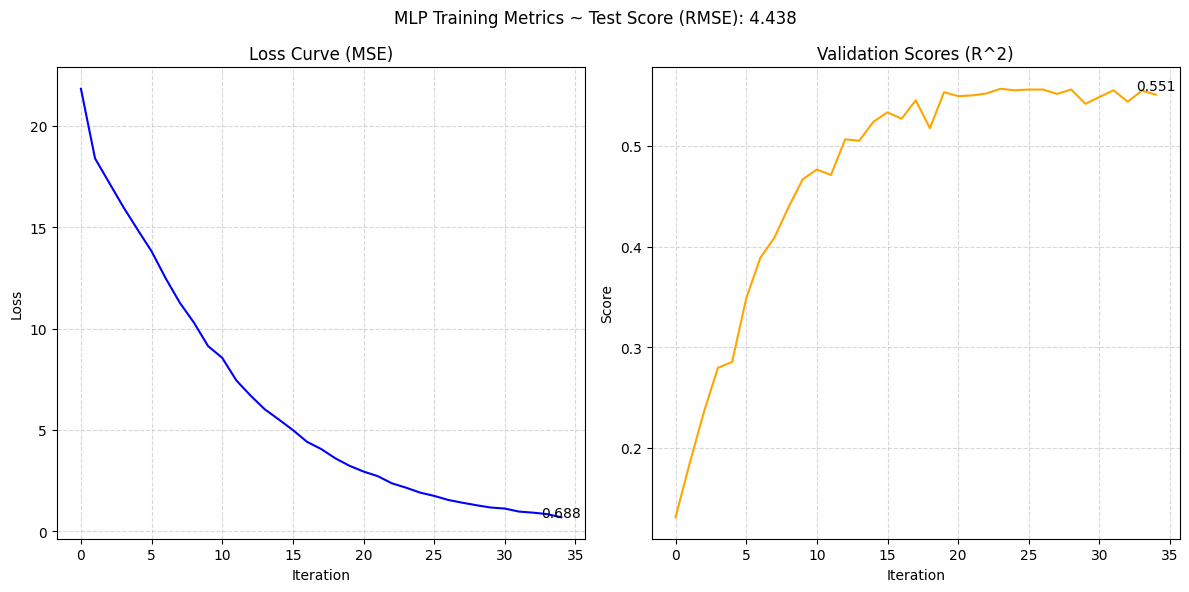

In [18]:
PLOTS_PATH = Path("./resources/figures")

def ensure_directory_exists(path: Path):
    """Ensure directory exists."""
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)

def fit_and_predict_mlp(model: MLPRegressor, plot_metrics: bool = True) -> None:
    # Combine training and validation datasets
    X_train_MLP = np.concatenate([X_train, X_valid])
    y_train_MLP = np.concatenate([y_train, y_valid])
    
    # Fit the MLP model
    model.fit(X_train_MLP, y_train_MLP)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE
    
    if plot_metrics:
        # Ensure the directory for storing plots exists
        ensure_directory_exists(PLOTS_PATH)

        # Setup for plotting
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
        iteration_point = len(model.loss_curve_) - 1  # Last iteration index
        label_offset = 0.005  # Offset for label placement

        # Plot training loss curve
        axs[0].plot(model.loss_curve_, color="blue")
        axs[0].text(iteration_point, model.loss_curve_[-1] + label_offset,
                    f"{model.loss_curve_[-1]:.3f}", ha="center")
        axs[0].set_title("Loss Curve (MSE)")
        axs[0].set_xlabel("Iteration")
        axs[0].set_ylabel("Loss")
        axs[0].grid(True, linestyle="--", alpha=0.5)

        # Plot validation scores curve
        axs[1].plot(model.validation_scores_, color="orange")
        axs[1].text(iteration_point, model.validation_scores_[-1] + label_offset,
                    f"{model.validation_scores_[-1]:.3f}", ha="center")
        axs[1].set_title("Validation Scores (R^2)")
        axs[1].set_xlabel("Iteration")
        axs[1].set_ylabel("Score")
        axs[1].grid(True, linestyle="--", alpha=0.5)

        # Set overall figure title and save the plot
        fig.suptitle(f"MLP Training Metrics ~ Test Score (RMSE): {rmse:.3f}")
        fig.savefig(PLOTS_PATH / "mlp_training_metrics.png")

# Example usage:
# Assuming 'regressors' is a dictionary with MLPRegressor instance as shown in previous parts.
fit_and_predict_mlp(regressors["MLP"])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

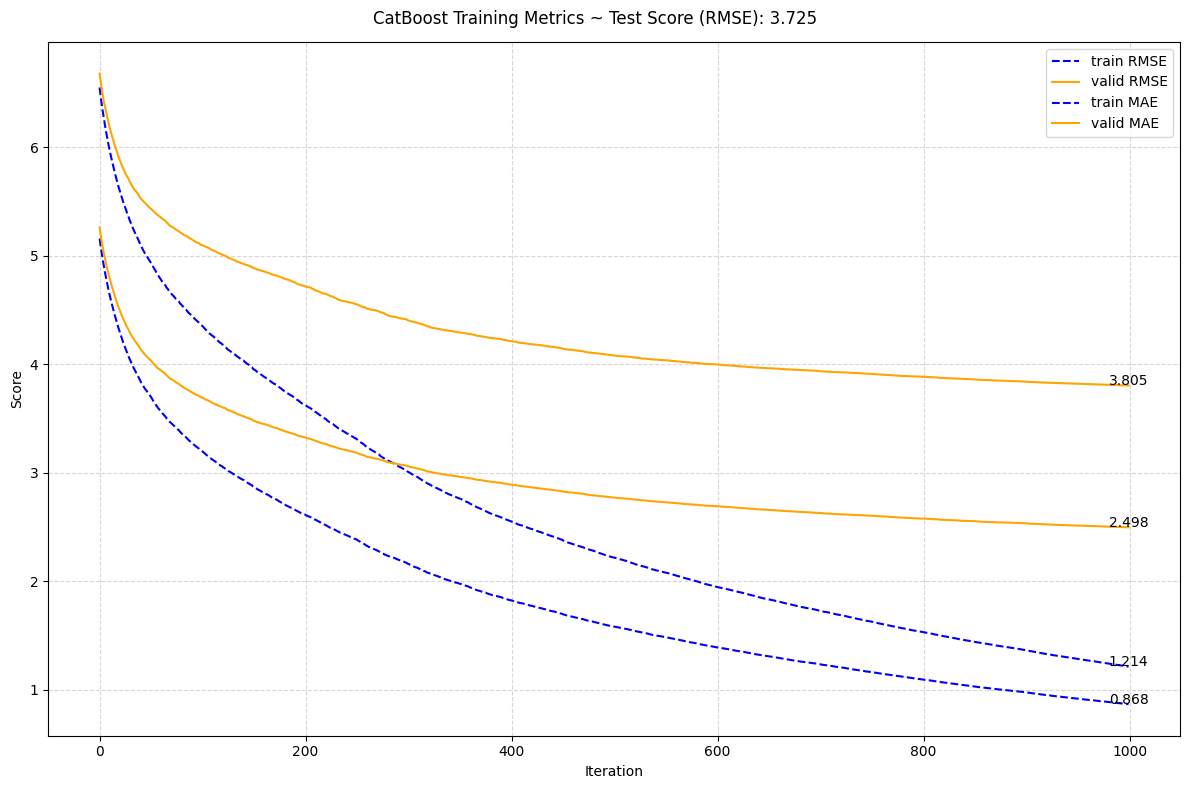

In [19]:
CATBOOST_INFO_PATH = Path("./catboost_info")
PLOTS_PATH = Path("./resources/figures")

def ensure_directory_exists(path: Path):
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)

def read_catboost_info_file(filename: str) -> tuple[pd.Series, pd.DataFrame]:
    df = pd.read_csv(CATBOOST_INFO_PATH / f"{filename}_error.tsv", sep="\t")
    return df["iter"], df.drop(columns=["iter"])

def root_mean_squared_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def fit_and_predict_catboost(model: CatBoostRegressor, plot_metrics: bool = True) -> None:
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=plot_metrics)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    if plot_metrics:
        ensure_directory_exists(PLOTS_PATH)
        train_iter, train_metrics = read_catboost_info_file("learn")
        valid_iter, valid_metrics = read_catboost_info_file("test")

        fig, axs = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
        max_iter = max(len(train_iter), len(valid_iter)) - 1
        label_offset = 0.005

        for metric in ["RMSE", "MAE"]:
            axs.plot(train_iter, train_metrics[metric], label=f"train {metric}", color="blue", linestyle="--")
            axs.text(max_iter, train_metrics[metric].iloc[-1] + label_offset, f"{train_metrics[metric].iloc[-1]:.3f}", ha="center")
            axs.plot(valid_iter, valid_metrics[metric], label=f"valid {metric}", color="orange")
            axs.text(max_iter, valid_metrics[metric].iloc[-1] + label_offset, f"{valid_metrics[metric].iloc[-1]:.3f}", ha="center")

        axs.set_xlabel("Iteration")
        axs.set_ylabel("Score")
        axs.grid(True, linestyle="--", alpha=0.5)
        axs.legend()
        fig.suptitle(f"CatBoost Training Metrics ~ Test Score (RMSE): {rmse:.3f}")
        fig.savefig(PLOTS_PATH / "catboost_training_metrics.png")

# Example usage
fit_and_predict_catboost(regressors["CatBoost"])